# 1. Relation between Precipitaion and Elevation for New jersey in year 2016


## 1. Data Collection

### 1.1 Download daily precipitation data from NASA for year 2016

Downloaded GPM Daily Precipitaion data from "https://measures.gesdisc.eosdis.nasa.gov/data/GPCP/GPCPDAY.3.1/2016/" 
 
  Code used in terminal
- echo "machine urs.earthdata.nasa.gov login danraj567 password ***************" > ~/.netrc
- chmod 0600 ~/.netrc

In [11]:
! wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies -r -np -A ".nc4" https://measures.gesdisc.eosdis.nasa.gov/data/GPCP/GPCPDAY.3.1/2016/

--2023-11-06 11:58:47--  http://precipitation_data/
Resolving precipitation_data (precipitation_data)... failed: Name or service not known.
wget: unable to resolve host address ‘precipitation_data’


### 1.2 DEM file USA

The DEM file is downloaded from https://github.com/HyDROSLab/EF5-US-Parameters/blob/master/basic/dem_usa.tif

In [12]:
! wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies -r -np -A ".tif" https://github.com/HyDROSLab/EF5-US-Parameters/blob/master/basic/

--2023-11-06 12:01:08--  https://github.com/HyDROSLab/EF5-US-Parameters/blob/master/basic/
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/HyDROSLab/EF5-US-Parameters/tree/master/basic [following]
--2023-11-06 12:01:08--  https://github.com/HyDROSLab/EF5-US-Parameters/tree/master/basic
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 2081 (2.0K) [text/plain]
Saving to: ‘github.com/HyDROSLab/EF5-US-Parameters/blob/master/basic/index.html’

100%[======================================>] 2,081       --.-K/s   in 0s      

2023-11-06 12:01:08 (4.78 MB/s) - ‘github.com/HyDROSLab/EF5-US-Parameters/blob/master/basic/index.html’ saved [2081/2081]

Removing github.com/HyDROSLab/EF5-US-Parameters/blob/master/basic/index.html since it should be rejected.

FINISHED --2023-11-06 12:01:08

### 1.3 Cities in New Jersey

The locations were taken from the "https://simplemaps.com/data/us-cities". 

## 1.4 Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import rasterio as rio

## 2.1 Extracting the coordinates of NJ from file.

# 2. Reading the Files

## 2.1 Reading CSV file

In [30]:
# Read the CSV file
df = pd.read_csv('uscities.csv')
df.head()


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18972871,10768.2,shape,False,True,America/New_York,1,11229 11226 11225 11224 11223 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,12121244,3267.6,shape,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90035 90034 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8595181,4576.6,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,5711945,4945.7,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7935,-96.7667,5668165,1522.2,shape,False,True,America/Chicago,1,75287 75098 75234 75254 75251 75252 75253 7503...,1840019440


In [31]:
# Filter for cities in New Jersey (NJ)
nj_cities = df[df['state_id'] == 'NJ']
# Count the number of cities in NJ
num_cities_nj = nj_cities['city'].nunique()
# Print the result
print(f"Total number of unique cities in New Jersey: {num_cities_nj}")
print("Cities in New Jersey:")
nj_cities.head()

Total number of unique cities in New Jersey: 655
Cities in New Jersey:


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
138,Trenton,Trenton,NJ,New Jersey,34021,Mercer,40.2237,-74.7641,316436,4232.8,shape,False,True,America/New_York,2,08638 08611 08618 08629 08609 08608 08601 0860...,1840001383
145,Newark,Newark,NJ,New Jersey,34013,Essex,40.7245,-74.1725,306247,4508.4,shape,False,True,America/New_York,2,07103 07102 07105 07104 07107 07106 07108 0711...,1840002791
156,Jersey City,Jersey City,NJ,New Jersey,34017,Hudson,40.7184,-74.0686,287146,6878.3,shape,False,True,America/New_York,2,07310 07311 07302 07307 07306 07305 07304 0709...,1840003600
195,Atlantic City,Atlantic City,NJ,New Jersey,34001,Atlantic,39.3797,-74.4527,236314,1356.1,shape,False,True,America/New_York,2,08401 08404 08405,1840003798
283,Paterson,Paterson,NJ,New Jersey,34031,Passaic,40.9147,-74.1624,157927,6676.6,shape,False,True,America/New_York,2,07522 07524 07514 07513 07504 07502 07505 0750...,1840000838


## 2.2 Reading NetCDF file

In [32]:
import xarray as xr
# Directory containing the NetCDF files 
nc_directory = 'Precipitation_data/'
# List all NetCDF files in the directory
nc_files = [os.path.join(nc_directory, f) for f in os.listdir(nc_directory) if f.endswith('.nc4')]
ds = xr.open_mfdataset(nc_files, combine='by_coords')
print(ds)

<xarray.Dataset>
Dimensions:                    (lon: 720, lat: 360, time: 366, bnds: 2)
Coordinates:
  * lon                        (lon) float32 -179.8 -179.2 ... 179.2 179.8
  * lat                        (lat) float32 89.75 89.25 88.75 ... -89.25 -89.75
  * time                       (time) datetime64[ns] 2016-01-01 ... 2016-12-31
Dimensions without coordinates: bnds
Data variables:
    precip                     (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    probability_liquid_precip  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    time_bnds                  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/67)
    ShortName:                      GPCPDAY
    LongName:                       GPCP Precipitation Level 3 Daily 0.5-Degr...
    VersionID:                      3.1
    GranuleID:                      GPCPDAY_L3_20160101_V3.1.nc4
    Format:                         N

## 2.3 Reading the DEM file

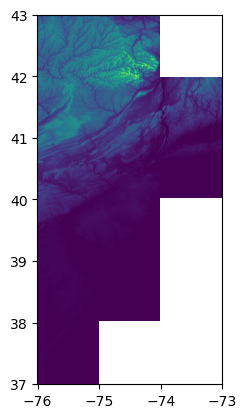

<Axes: >

In [6]:
from rasterio.plot import show
file_path = 'DEM.tif'
dem = rio.open(file_path) #Reading the DEM file
show(dem)

In [9]:
from rasterio.enums import Resampling
data = dem.read(
     out_shape=(
        dem.count,
        int(dem.height * 0.01),  # decreasing the resolution
        int(dem.width *0.01)
    ),
        resampling=Resampling.bilinear
)

    # Update the metadata to reflect the new shape
transform = dem.transform * dem.transform.scale(
    (dem.width / data.shape[-1]),
    (dem.height / data.shape[-2])
)

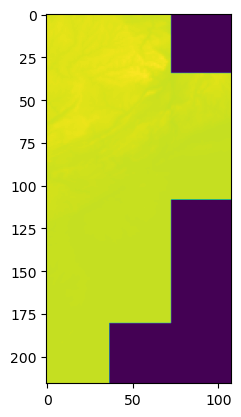

<Axes: >

In [10]:
show (data)

In [15]:
new_meta = dem.meta.copy()
new_meta.update({
    'driver': 'GTiff',
    'height': data.shape[1],
    'width': data.shape[2],
    'transform': transform
})

 
with rio.open('resampled_DEM.tif', 'w', **new_meta) as dst:
    dst.write(data)

## 3. Process

### 3.1 Reading the elevation from DEM from the lat and lng of cities

In [18]:
# Function to get elevation from resampled DEM based on coordinates
def get_elevation(lat, lon, dem):
    row, col = dem.index(lon, lat)
    if (0 <= row < dem.height) and (0 <= col < dem.width):
        return dem.read(1)[row, col]
    else:
        return None  # Return None for coordinates outside the DEM bounds


In [19]:
# Read the resampled DEM file
with rio.open('resampled_DEM.tif') as dem:
    # Add a new column to the DataFrame for elevation
    nj_cities['elevation'] = nj_cities.apply(lambda row: get_elevation(row['lat'], row['lng'], dem), axis=1)

# Select only the relevant columns
nj_cities_subset = nj_cities[['city', 'lat', 'lng', 'elevation']]

# Display the DataFrame with city names, lat, lng, and elevation
print(nj_cities_subset)

                city      lat      lng   elevation
138          Trenton  40.2237 -74.7641   24.867914
145           Newark  40.7245 -74.1725   23.419693
156      Jersey City  40.7184 -74.0686    9.510970
195    Atlantic City  39.3797 -74.4527    0.850331
283         Paterson  40.9147 -74.1624   31.753309
...              ...      ...      ...         ...
29672   Gandys Beach  39.2715 -75.2316    0.163631
29940     Buttzville  40.8293 -75.0060  172.623993
30125    Pine Valley  39.7870 -74.9742   38.724731
30260   Money Island  39.2855 -75.2352    0.618595
30317      Tavistock  39.8758 -75.0273   19.213404

[656 rows x 4 columns]


/tmp/ipykernel_136122/3665094710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nj_cities['elevation'] = nj_cities.apply(lambda row: get_elevation(row['lat'], row['lng'], dem), axis=1)


In [20]:
# Export the DataFrame to a CSV file
nj_cities_subset.to_csv('nj_cities_elevation.csv', index=False)

## 3.2 Reading the datas from the NetCDF file for  'lat', 'lng'

In [33]:
# Function to get precipitation for a given lat, lon
def get_precip(lat, lon, ds):
    # Find the nearest point (might need adjustment based on your data's resolution)
    precip = ds.sel(lat=lat, lon=lon, method='nearest')['precip']
    return precip



In [38]:
# Dictionary to store accumulated monthly precipitation data
city_monthly_precip = {}

# Loop through each city
for index, row in nj_cities.iterrows():
    city_name = row['city']
    lat, lon = row['lat'], row['lng']
    
    # Extract precipitation data
    precip_data = get_precip(lat, lon, ds)
    
    # Convert to DataFrame
    precip_df = precip_data.to_dataframe().reset_index()
    
    # Resample to get monthly data and sum the precipitation
    monthly_precip = precip_df.resample('M', on='time')['precip'].mean()
    
    city_monthly_precip[city_name] = monthly_precip

In [40]:
city_precip_df = pd.DataFrame(city_monthly_precip)

# Transpose the DataFrame to have cities as rows and months as columns
city_precip_df = city_precip_df.T

# Reset the index to turn the city names into a column
city_precip_df.reset_index(inplace=True)
city_precip_df.rename(columns={'index': 'City'}, inplace=True)

# Export the DataFrame to a CSV file
city_precip_df.to_csv('city_monthly_mean_precipitation.csv', index=False)


Data exported to 'city_monthly_mean_precipitation.csv'


## 4. Plotting Relations

In [3]:
precip=pd.read_csv('city_monthly_mean_precipitation.csv')

In [4]:
ele=pd.read_csv('nj_cities_elevation.csv')

In [5]:
precip.head()

,City,2016-01-31 00:00:00,2016-02-29 00:00:00,2016-03-31 00:00:00,2016-04-30 00:00:00,2016-05-31 00:00:00,2016-06-30 00:00:00,2016-07-31 00:00:00,2016-08-31 00:00:00,2016-09-30 00:00:00,2016-10-31 00:00:00,2016-11-30 00:00:00,2016-12-31 00:00:00
0,Trenton,3.304875,4.391598,1.467667,1.797601,3.765642,2.051863,4.893903,1.684880,2.428081,2.227747,3.513835,2.562721
1,Newark,3.292070,4.365805,1.311810,1.748018,3.209475,1.745682,4.529283,1.651393,1.606720,2.095352,4.518718,2.674876
2,Jersey City,3.292070,4.365805,1.311810,1.748018,3.209475,1.745682,4.529283,1.651393,1.606720,2.095352,4.518718,2.674876
3,Atlantic City,2.815738,4.119709,2.591657,2.777713,5.164398,2.244443,5.891844,1.659229,5.019808,3.064476,1.004424,3.068614
4,Paterson,3.292070,4.365805,1.311810,1.748018,3.209475,1.745682,4.529283,1.651393,1.606720,2.095352,4.518718,2.674876


In [6]:
ele.head()

,city,lat,lng,elevation
0,Trenton,40.2237,-74.7641,24.867914
1,Newark,40.7245,-74.1725,23.419693
2,Jersey City,40.7184,-74.0686,9.510970
3,Atlantic City,39.3797,-74.4527,0.850331
4,Paterson,40.9147,-74.1624,31.753310
